# CSC2541 Machine Learning For Health Assignment 1
# Pulkit Mathur
# 1005483692

In [94]:
import numpy as np
import pandas as pd
import gensim
import pickle
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Part 2a: 
## Adult ICU data

In [18]:
adult_icu = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_icu")
adult_icu.head()

,subject_id,hadm_id,icustay_id,age,mort_icu,first_hosp_stay,first_icu_stay,adult_icu,eth_asian,eth_black,...,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,train
0,3,145834,211552,76.0,0,1,1,1,0,0,...,4.8,282.0,5.4,30.7,1.3,13.5,136.0,53.0,12.7,0
1,6,107064,228232,65.0,0,1,1,1,0,0,...,8.5,315.0,5.4,139.0,1.4,14.6,138.0,62.0,10.6,0
2,9,150750,220597,41.0,1,1,1,1,0,0,...,2.9,258.0,2.8,21.7,1.1,12.7,140.0,16.0,7.5,1
3,12,112213,232669,72.0,0,1,1,1,0,0,...,6.6,156.0,4.9,55.2,1.7,15.9,138.0,28.0,8.4,1
4,13,143045,263738,39.0,0,1,1,1,0,0,...,3.9,216.0,3.5,44.1,1.2,13.7,139.0,13.0,16.6,1


## Getting train and test data

In [20]:
adult_icu = adult_icu.drop(['subject_id','hadm_id','icustay_id'],axis=1)
Y = adult_icu[['mort_icu','train']] 
Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()

X_train,X_test = adult_icu.loc[adult_icu['train']==1],adult_icu.loc[adult_icu['train']==0]
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

#### Scaling the non-boolean columns

In [23]:
drop_columns = ['train','mort_icu']
bool_cols = [col for col in adult_icu if np.isin(adult_icu[col].dropna().unique(),[0, 1]).all()]
non_bool_cols = [item for item in adult_icu.columns if item not in bool_cols]
#Scaling the data

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_scaled,X_test_scaled = scaler.fit_transform(X_train[non_bool_cols]),scaler.fit_transform(X_test[non_bool_cols])
X_train_scaled,X_test_scaled = pd.DataFrame(X_train_scaled, columns=non_bool_cols),pd.DataFrame(X_test_scaled, columns=non_bool_cols)
X_train_scaled,X_test_scaled = X_train_scaled.join(X_train[bool_cols]),X_test_scaled.join(X_test[bool_cols])
X_train_scaled,X_test_scaled = X_train_scaled.drop(drop_columns,axis=1),X_test_scaled.drop(drop_columns,axis=1)

## Training a Logistic regression with l2 regularizer

AUC:  77.7503729825


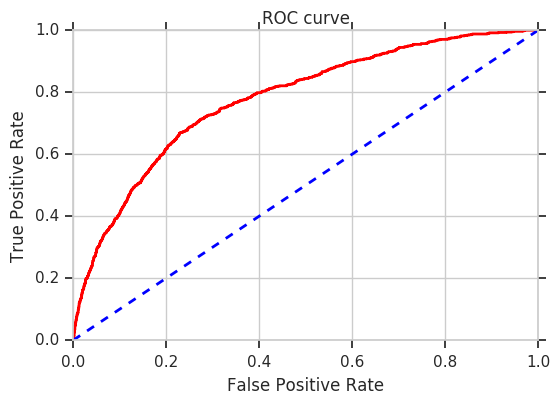

In [51]:
classifier = LogisticRegression(random_state=0,penalty="l2", C=3)
classifier.fit(X_train_scaled, Y_train)
Y_pred = classifier.predict(X_test_scaled)
Y_test_prob = classifier.predict_proba(X_test_scaled)
auc_model1 = roc_auc_score(Y_test,Y_test_prob[:,1])
print("AUC: ",roc_auc_score(Y_test,Y_test_prob[:,1])*100)

fpr, tpr,_=roc_curve(Y_test,Y_test_prob[:,1],pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Top 5 risk factors

In [25]:
Coef_table=pd.DataFrame()
Coef_table['Risk factors'] = X_train_scaled.columns[:]
Coef_table['coef'] = classifier.coef_[0]
Coef_table = Coef_table.sort_values('coef')
Coef_table.iloc[-5:]

,Risk factors,coef
25,aniongap,2.561217
12,meanbp_mean,2.720808
17,tempc_max,3.057897
44,wbc,3.358029
28,bilirubin,3.944281


###### Explanation:
Bilirubin - Bilirubin is a yellowish substance in your blood. It forms after red blood cells break down, and it travels through your liver, gallbladder, and digestive tract before being excreted. High Bilirubin usually results when liver is not functioning properly which can be due to many factors like 

meanbp_mean - Blood pressure outside the normal range can be g=harmful. High blood pressure can results in damamge to artries , brain, heart, kidneys , eyes etc whereas a low blood pressure can result in hypotension which in extreme case can be life threatning.

tempc_max- 

wbc- White blooad cell plays a significant role in our body. If the count of WBC changes from normal then it can be harmful for the body. Low WBC count can cause Infection, Anemia, Bleeding where as, if wbc are present in higher amount than normal then these can stuck in the artries and harden, which causes plaque to build up and can lead to heart attacks.Besides a hardening of the arteries, a higher number of white blood cells cause problems with circulation, thicker blood, and the increase of proinflammatory cytokines.

Anion Gap = Na+ – (Cl- + HCO3-) is used for the evaluation of metabolic acidosis to determine the presence of unmeasured anions.
High or lower value of Anion gap can be harmful as explained-

High Anion gap occurs when our body starts producing acid(ketoacid) in larger amount than usual this results into condition known as acidosis which can have following harmful effects- shortness of breath, increased heart rate, jaundice, fatigue or drowsiness etc.

Since, all these factors if not taken care can result in life threatning diseases. Hence, it seems justified that they have a strong corelation with mortality rate.

### Lowest 5 risk factor

In [26]:
Coef_table.iloc[:5]

,Risk factors,coef
16,tempc_min,-2.932108
37,platelet,-2.762496
18,tempc_mean,-2.654793
33,hemoglobin,-2.420074
4,sysbp_min,-2.233325


###### Explanation:
Platelet - A low platelet is usually called thrombocytopenia. This condition can range from mild to severe, depending on its underlying cause. For some, the symptoms can include severe bleeding and are possibly fatal if they’re not treated. Hence, it is negatively coorelated to mortality rate.

But, 

Hemoglobin - 

# ---------------------------------------------------------------------------------------------------------------
# Part 2(b):
## Adult Notes Data

In [74]:
adult_notes_raw = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/adult_notes")
adult_notes_raw.head()

,subject_id,hadm_id,icustay_id,chartext,train,mort_icu
0,3,145834,211552,[**2101-10-21**] 1:00 AM\n CHEST (PORTABLE AP)...,0,0
1,6,107064,228232,[**2175-5-31**] 11:03 AM\n RENAL TRANSPLANT U....,0,0
2,9,150750,220597,[**2149-11-10**] 11:07 AM\n CT HEAD W/O CONTRA...,1,1
3,12,112213,232669,ADMIT NOTE\nPLEASE SEE ADMISSION HISTORY/FHP.\...,1,0
4,13,143045,263738,[**2167-1-9**] 6:11 AM\n CHEST (PORTABLE AP) ...,1,0


## Deleting punctuation

In [75]:
adult_notes_raw = adult_notes_raw.drop(['subject_id','hadm_id','icustay_id'],axis=1)
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
adult_notes_raw['chartext'].dropna(inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: tokenizer.tokenize(x))
adult_notes_raw.head()

,chartext,train,mort_icu
0,"[2101, 10, 21, 1, 00, AM, CHEST, PORTABLE, AP,...",0,0
1,"[2175, 5, 31, 11, 03, AM, RENAL, TRANSPLANT, U...",0,0
2,"[2149, 11, 10, 11, 07, AM, CT, HEAD, W, O, CON...",1,1
3,"[ADMIT, NOTE, PLEASE, SEE, ADMISSION, HISTORY,...",1,0
4,"[2167, 1, 9, 6, 11, AM, CHEST, PORTABLE, AP, C...",1,0


## Deleting stopwords

In [76]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
adult_notes_raw['chartext'].dropna(inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: [item for item in x if item not in stop_words])
#handling null values if any
adult_notes_raw['chartext'].fillna("empty", inplace=True)
adult_notes_raw.chartext = adult_notes_raw.chartext.apply(lambda x: ' '.join(map(str, x)))
adult_notes_raw.to_pickle('adult_notes_raw')

In [78]:
adult_notes_raw = pd.read_pickle('adult_notes_raw')

## Getting train and test data

In [30]:
#train-test-split
X_train_notes,X_test_notes = adult_notes_raw.loc[adult_notes_raw['train']==1],adult_notes_raw.loc[adult_notes_raw['train']==0]
X_train_notes,X_test_notes = X_train_notes.drop(drop_columns,axis=1),X_test_notes.drop(drop_columns,axis=1)
Y2 = adult_notes_raw[['mort_icu','train']] 
Y_train_notes,Y_test_notes = Y2.loc[Y2['train']==1],Y2.loc[Y2['train']==0]
Y_train_notes,Y_test_notes = Y_train_notes.drop(['train'],axis=1).values.squeeze(),Y_test_notes.drop(['train'],axis=1).values.squeeze()

## Tf-idf Tokenizer

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X_train_notes = v.fit_transform(np.array(X_train_notes['chartext']))
X_test_notes = v.transform(np.array(X_test_notes['chartext']))

## Training a Logistic regression with l1 regularizer

AUC:  83.984733148


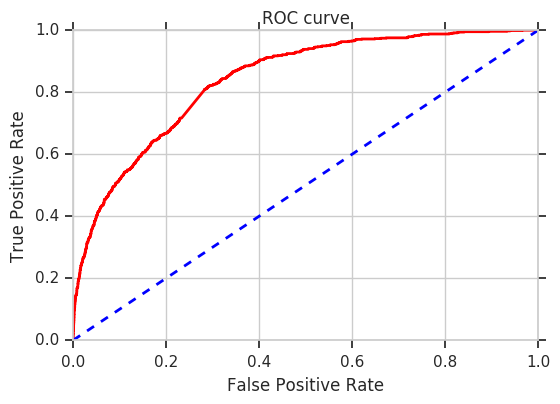

In [54]:
notes_classifier = LogisticRegression(random_state=0,penalty="l1", C=2)
notes_classifier.fit(X_train_notes, Y_train_notes)
Y_pred_notes = notes_classifier.predict(X_test_notes)
#matrix = confusion_matrix(Y_test_notes, Y_pred_notes)
Y_test_notes_prob = notes_classifier.predict_proba(X_test_notes)
#print(matrix)
#print("Accuracy: ",notes_classifier.score(X_train_notes, Y_train_notes))
auc_model2 = roc_auc_score(Y_test_notes,Y_test_notes_prob[:,1])
print("AUC: ",roc_auc_score(Y_test_notes,Y_test_notes_prob[:,1])*100)
fpr, tpr,_=roc_curve(Y_test_notes,Y_test_notes_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Top 5 words associated with high mortality

In [33]:
Coef_table=pd.DataFrame()
Coef_table['Words'] = v.get_feature_names()
Coef_table['coef'] = notes_classifier.coef_[0]
Coef_table = Coef_table.sort_values('coef')
Coef_table.iloc[-5:]

,Words,coef
87737,death,7.426595
134053,paucity,8.095111
92027,dnr,8.459544
85169,corneal,12.987259
140117,prognosis,13.633352


###### Explanation:

Prognosis is a medical term for predicting the likely or expected development of a disease. 
Death is a synonym of mortality
Paucity means lack of, most of the time doctors uses this term to signify that the patient body has very less number of some vital elements (that are crucial for survival) left.
Corneal - People donates their cornea after their death.
dnr - 


### Lowest 5 words associated with high mortality

In [34]:
Coef_table.iloc[:5]

,Words,coef
90112,diet,-20.383519
99007,extubation,-11.223441
81476,clear,-9.366060
98990,extubated,-9.030652
170311,weaned,-8.386581


###### Explanation:

# --------------------------------------------------------------------------------------------------------------
# Part 2(c):

In [62]:
Y_merged_prob = (auc_model1*Y_test_prob) + (auc_model2*Y_test_notes_prob)

In [59]:
Y_merged_prob = (Y_test_prob+Y_test_notes_prob)/2

AUC:  85.1181845924


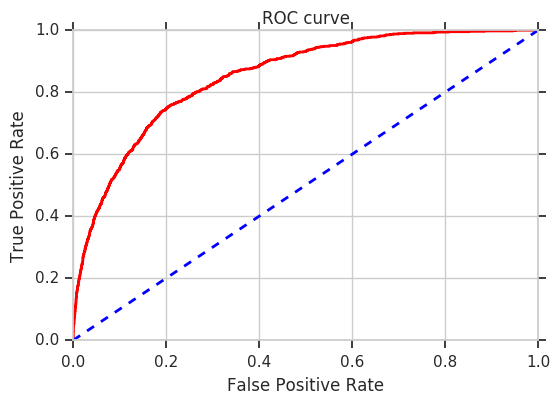

In [63]:
auc_model3 = roc_auc_score(Y_test_notes,Y_merged_prob[:,1])
print("AUC: ",roc_auc_score(Y_test_notes,Y_merged_prob[:,1])*100)
fpr, tpr,_=roc_curve(Y_test_notes,Y_merged_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Explanation:

# --------------------------------------------------------------------------------------------------------------- Part 3(a)


# --------------------------------------------------------------------------------------------------------------
# Part 4(a):

In [79]:
adult_notes_lda = adult_notes_raw.drop(["train","mort_icu"],axis=1)
text_data=[]
for i in range(adult_notes_lda.shape[0]):
    text_data.append(adult_notes_lda['chartext'][i].split())

In [23]:
#create dictionary
dictionary = corpora.Dictionary(text_data)
#Term document frequency
corpus = [dictionary.doc2bow(text) for text in text_data]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [80]:
dictionary = corpora.Dictionary.load('dictionary.gensim') 
corpus = [dictionary.doc2bow(text) for text in text_data]

In [88]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 20, id2word=dictionary)
ldamodel.save('model20.gensim')

In [89]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 50, id2word=dictionary)
ldamodel.save('model50.gensim')

In [90]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 100, id2word=dictionary)
ldamodel.save('model100.gensim')

In [92]:
ldamodel = gensim.models.ldamodel.LdaModel.load('model20.gensim')

In [97]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=ldamodel, corpus=corpus ,dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -0.74613090643


In [91]:
words = [' respiratory','vomiting', 'urine', 'pulse']
ldamodel = gensim.models.ldamodel.LdaModel.load('model20.gensim')
topics = ldamodel.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.268*"2188" + 0.005*"2206" + 0.003*"1" + 0.003*"3" + 0.003*"5" + 0.002*"2" + 0.002*"7" + 0.002*"CT" + 0.002*"No" + 0.002*"right" + 0.002*"AM" + 0.002*"4" + 0.002*"left" + 0.002*"Name" + 0.002*"6" + 0.001*"pt" + 0.001*"0" + 0.001*"Clip" + 0.001*"The" + 0.001*"9"')
(1, '0.020*"artery" + 0.012*"right" + 0.012*"The" + 0.009*"aneurysm" + 0.009*"left" + 0.009*"Numeric" + 0.009*"Identifier" + 0.009*"Name" + 0.007*"Last" + 0.007*"carotid" + 0.007*"Clip" + 0.006*"2" + 0.006*"procedure" + 0.006*"catheter" + 0.005*"common" + 0.005*"______________________________________________________________________________" + 0.005*"A" + 0.005*"patient" + 0.005*"1" + 0.005*"embolization"')
(2, '0.028*"trach" + 0.026*"2104" + 0.022*"2106" + 0.020*"2169" + 0.017*"p" + 0.015*"HD" + 0.009*"e" + 0.009*"Pt" + 0.007*"m" + 0.007*"t" + 0.007*"y" + 0.007*"ESRD" + 0.006*"tracheal" + 0.006*"2" + 0.005*"PEG" + 0.005*"rehab" + 0.005*"Trach" + 0.005*"1" + 0.004*"pt" + 0.004*"dialysis"')
(3, '0.016*"liver" + 0.011*"cirr